In [1]:
%matplotlib inline
from __future__ import print_function, division
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from utils.metrics import (
    threshold_at_completeness_of,
    threshold_at_purity_of,
    get_purity,
    get_completeness,
    bayes_conf,
    get_interval,
    get_bayes_interval,
    calibration_error
    )

In [2]:
df = pd.read_csv("sdss_test.csv")
mag_r = df["dered_r"].values

In [3]:
morph_true, morph_pred = np.loadtxt('sdss_tpc.2.mlz', unpack=True, usecols=(0, 2))
morph_pred = 1.0 - morph_pred # make galaxy=0 and star=1

In [4]:
phot_true, phot_pred = np.loadtxt('sdss_tpc.3.mlz', unpack=True, usecols=(0, 2))
phot_pred = 1.0 - phot_pred # make galaxy=0 and star=1

In [5]:
y_true = np.load("sdss_test_labels.npy")
cnn_pred = np.load("sdss_convnet_pred.npy")

cnn_pred = 1.0 - cnn_pred # make galaxy=0 and star=1
y_true = (1.0 - y_true) / 2 # make galaxy=0 and star=1

In [6]:
mask = ((mag_r > -90) & (mag_r < 90))
mag_r, y_true, cnn_pred, phot_pred, morph_pred = map(
    lambda x: x[mask],
    [mag_r, y_true, cnn_pred, phot_pred, morph_pred]
)

In [7]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_true, cnn_pred))
print(roc_auc_score(y_true, morph_pred))
print(roc_auc_score(y_true, phot_pred))

0.995161246423
0.996714806395
0.98856608602


In [8]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_true, cnn_pred))
print(mean_squared_error(y_true, morph_pred))
print(mean_squared_error(y_true, phot_pred))

0.0181964385141
0.00985514553333
0.0283448357687


In [9]:
cnn_p_cut, _ = threshold_at_completeness_of(y_true, cnn_pred, 0.96)
morph_p_cut, _ = threshold_at_completeness_of(y_true, morph_pred, 0.96)
phot_p_cut, _ = threshold_at_completeness_of(y_true, phot_pred, 0.96)

print(get_purity(y_true, cnn_pred, cnn_p_cut))
print(get_purity(y_true, morph_pred, morph_p_cut))
print(get_purity(y_true, phot_pred, phot_p_cut))

0.991458607096
0.997733711048
0.98187226922


In [10]:
cnn_p_cut, _ = threshold_at_purity_of(1 - y_true, 1 - cnn_pred, 0.97)
morph_p_cut, _ = threshold_at_purity_of(1 - y_true, 1 - morph_pred, 0.97)
phot_p_cut, _ = threshold_at_purity_of(1 - y_true, 1 - phot_pred, 0.97)

print(get_completeness(1 - y_true, 1 - cnn_pred, cnn_p_cut))
print(get_completeness(1 - y_true, 1 - morph_pred, morph_p_cut))
print(get_completeness(1 - y_true, 1 - phot_pred, phot_p_cut))

0.0242682011509
0.980985739304
0.887915936953


In [11]:
def all_threshold_at_purity_of(y_true, y_pred, threshold):

    thresholds = np.sort(y_pred)
    purity = np.zeros_like(thresholds)

    for i, t in enumerate(thresholds):
        purity[i] = get_purity(y_true, y_pred, t)

    purity = purity[~np.isnan(purity)]

    idx = np.where(np.abs(purity - threshold) < 0.0001)[0]

    return thresholds[idx], purity[idx]

In [12]:
print(all_threshold_at_purity_of(1 - y_true, 1 - cnn_pred, 0.97))

(array([ 0.60315662,  0.60369459,  0.60376087,  0.60458069,  0.60463386,
        0.99983626,  0.99986711]), array([ 0.97004608,  0.97003841,  0.97003074,  0.97002306,  0.97001538,
        0.96992481,  0.97      ]))


In [13]:
cnn_p_cut = 0.60463386

In [14]:
print(get_completeness(1 - y_true, 1 - cnn_pred, cnn_p_cut))
print(get_completeness(1 - y_true, 1 - morph_pred, morph_p_cut))
print(get_completeness(1 - y_true, 1 - phot_pred, phot_p_cut))

0.946960220165
0.980985739304
0.887915936953


In [16]:
print(calibration_error(y_true, cnn_pred, 1000))
print(calibration_error(y_true, morph_pred, 1000))
print(calibration_error(y_true, phot_pred, 1000))

0.0242687998704
0.0254050393606
0.0316462999929


In [12]:
print(((cnn_true == 1).sum() - (cnn_pred).sum()) / (cnn_true == 1).sum())
print(((morph_true == 1).sum() - (morph_pred).sum()) / (morph_true == 1).sum())
print(((phot_true == 1).sum() - (phot_pred).sum()) / (phot_true == 1).sum())

0.0156652093991
-0.00441581386894
-0.0160085703899


In [13]:
n_bins = 10
p_gal_low, p_gal_med, p_gal_high = get_bayes_interval(
    cnn_true, cnn_pred, n_bins=n_bins, step=0.005)
p_sg_low, p_sg_med, p_sg_high = get_interval(cnn_pred, n_bins=n_bins)

Done. N = 3514, k = 36, area: 0.684, alpha: 0.0090, beta: 0.0125
Done. N = 187, k = 26, area: 0.683, alpha: 0.1193, beta: 0.1706
Done. N = 104, k = 16, area: 0.683, alpha: 0.1258, beta: 0.1971
Done. N = 102, k = 40, area: 0.682, alpha: 0.3560, beta: 0.4550
Done. N = 80, k = 41, area: 0.682, alpha: 0.4653, beta: 0.5769
Done. N = 116, k = 76, area: 0.684, alpha: 0.6144, beta: 0.7026
Done. N = 137, k = 111, area: 0.683, alpha: 0.7782, beta: 0.8453
Done. N = 237, k = 210, area: 0.684, alpha: 0.8667, beta: 0.9084
Done. N = 470, k = 441, area: 0.684, alpha: 0.9293, beta: 0.9527
Done. N = 10053, k = 10006, area: 1.000, alpha: 0.9960, beta: 1.0000


/usr/local/lib/python3.4/dist-packages/scipy/integrate/quadpack.py:321: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


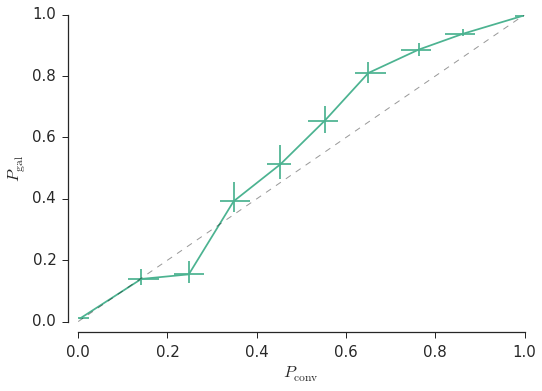

In [14]:
import seaborn as sns

sns.set(style="ticks", font_scale=1.5, color_codes=True)

fig, ax = plt.subplots()

sns.despine(trim=True, offset=10)

ax.errorbar(
    p_sg_med, p_gal_med, color="#4CB391",
    xerr=[p_sg_med - p_sg_low, p_sg_high - p_sg_med],
    yerr=[p_gal_med - p_gal_low, p_gal_high - p_gal_med]
)
ax.plot((0, 1), (0, 1), ls="--", color="#000000", alpha=0.4, linewidth=1)
ax.set_xlabel(r'$P_{\mathrm{conv}}$')
ax.set_ylabel(r'$P_{\mathrm{gal}}$')

plt.savefig('figures/sdss_calibration_conv.pdf', bbox_inches='tight')

In [15]:
n_bins = 10
p_tpc_gal_low, p_tpc_gal_med, p_tpc_gal_high = get_bayes_interval(
    morph_true, morph_pred,
    n_bins=n_bins, step=0.01
)
p_tpc_sg_low, p_tpc_sg_med, p_tpc_sg_high = get_interval(morph_pred, n_bins=n_bins)

Done. N = 1132, k = 24, area: 0.683, alpha: 0.0180, beta: 0.0268
Done. N = 21, k = 8, area: 0.683, alpha: 0.3040, beta: 0.5120
Done. N = 22, k = 8, area: 0.683, alpha: 0.2800, beta: 0.4780
Done. N = 15, k = 5, area: 0.683, alpha: 0.2300, beta: 0.4600
Done. N = 15, k = 7, area: 0.684, alpha: 0.3635, beta: 0.6086
Done. N = 14, k = 7, area: 0.682, alpha: 0.3800, beta: 0.6300
Done. N = 13, k = 8, area: 0.684, alpha: 0.5056, beta: 0.7620
Done. N = 17, k = 11, area: 0.683, alpha: 0.5300, beta: 0.7500
Done. N = 30, k = 21, area: 0.683, alpha: 0.6320, beta: 0.8000
Done. N = 10977, k = 10895, area: 1.000, alpha: 0.9900, beta: 1.0000


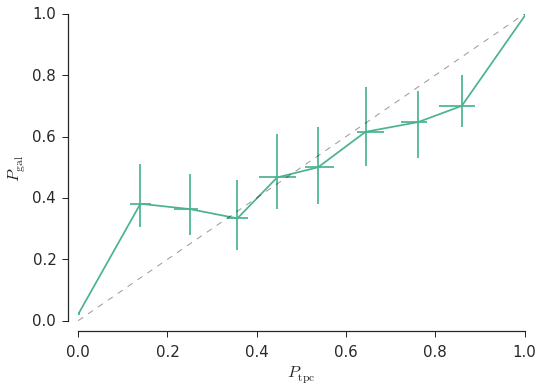

In [16]:
import seaborn as sns

sns.set(style="ticks", font_scale=1.5, color_codes=True)

fig, ax = plt.subplots()

sns.despine(trim=True, offset=10)

ax.errorbar(
    p_tpc_sg_med, p_tpc_gal_med, color="#4CB391",
    xerr=[p_tpc_sg_med - p_tpc_sg_low, p_tpc_sg_high - p_tpc_sg_med],
    yerr=[p_tpc_gal_med - p_tpc_gal_low, p_tpc_gal_high - p_tpc_gal_med]
)
ax.plot((0, 1), (0, 1), ls="--", color="#000000", alpha=0.4, linewidth=1)
ax.set_xlabel(r'$P_{\mathrm{tpc}}$')
ax.set_ylabel(r'$P_{\mathrm{gal}}$')

plt.savefig('figures/sdss_calibration_tpc.pdf', bbox_inches='tight')